# Generación de Música con Cadenas de Markov

Este notebook implementa un generador de melodías usando **cadenas de Markov de orden superior**.

### Contenido:
- **Parte A**: Método tradicional (Markov sobre notas)
- **Parte B**: Método de Xu (2023) - Markov para acordes + Lagrange para melodía
- **Parte C**: Evaluación con Cross-Entropy y otras métricas

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from music21 import converter, note, chord, stream, instrument, pitch, key
from typing import List, Tuple, Dict, Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import lagrange as scipy_lagrange, PchipInterpolator
from scipy.stats import entropy
import os
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

def get_project_root() -> Path:
    """
    Encuentra el directorio raíz del proyecto buscando 'midis'.
    Busca primero en el directorio actual y padres, luego en ubicaciones conocidas.
    """
    current = Path.cwd()
    
    # Buscar en directorio actual y padres
    if (current / 'midis').exists():
        return current
    for parent in current.parents:
        if (parent / 'midis').exists():
            return parent
    
    # Buscar en ubicaciones conocidas del proyecto
    ubicaciones_conocidas = [
        Path.home() / 'Documents/universidad/2025-II/cadenas/proyecto/esnupi_de_markov',
    ]
    for ubicacion in ubicaciones_conocidas:
        if ubicacion.exists() and (ubicacion / 'midis').exists():
            return ubicacion
    
    raise FileNotFoundError(
        "No se encontró el directorio del proyecto.\n"
        "Opciones:\n"
        "  1. Mover este notebook al directorio del proyecto\n"
        "  2. Agregar la ruta a 'ubicaciones_conocidas' en get_project_root()"
    )

PROJECT_ROOT = get_project_root()
print(f"Directorio del proyecto: {PROJECT_ROOT}")


Directorio del proyecto: /Users/juli/Documents/universidad/2025-II/cadenas/proyecto/esnupi_de_markov


---
# PARTE A: Método Tradicional (Markov sobre Notas)
---

## 1. Cadena de Markov de Orden Superior

In [2]:
class CadenaDeMarkov:
    """
    Cadena de Markov de orden n para generación de secuencias.
    """
    
    def __init__(self, orden: int = 2):
        self.orden = orden
        self.transiciones: Dict[tuple, Counter] = defaultdict(Counter)
        self.secuencias_iniciales: List[tuple] = []
        self.estados: set = set()
    
    def entrenar(self, secuencia: List[Any]) -> None:
        if len(secuencia) < self.orden + 1:
            print(f"Secuencia muy corta para orden {self.orden}")
            return
        self.secuencias_iniciales.append(tuple(secuencia[:self.orden]))
        self.estados.update(secuencia)
        for i in range(len(secuencia) - self.orden):
            contexto = tuple(secuencia[i:i + self.orden])
            siguiente = secuencia[i + self.orden]
            self.transiciones[contexto][siguiente] += 1
    
    def obtener_probabilidades(self, contexto: tuple) -> Dict[Any, float]:
        conteos = self.transiciones[contexto]
        total = sum(conteos.values())
        if total == 0:
            return {}
        return {estado: conteo / total for estado, conteo in conteos.items()}
    
    def generar_siguiente(self, contexto: List[Any], temperatura: float = 1.0) -> Any:
        ctx = tuple(contexto[-self.orden:])
        conteos = self.transiciones[ctx]
        if not conteos:
            return list(self.estados)[np.random.randint(len(self.estados))]
        estados = list(conteos.keys())
        probs = np.array([conteos[e] for e in estados], dtype=float)
        probs /= probs.sum()
        if temperatura != 1.0 and len(probs) > 1:
            probs = np.power(probs, 1.0 / temperatura)
            probs /= probs.sum()
        return estados[np.random.choice(len(estados), p=probs)]
    
    def generar_secuencia(self, longitud: int, temperatura: float = 1.0) -> List[Any]:
        if not self.secuencias_iniciales:
            return []
        idx = np.random.randint(len(self.secuencias_iniciales))
        secuencia = list(self.secuencias_iniciales[idx])
        while len(secuencia) < longitud:
            siguiente = self.generar_siguiente(secuencia, temperatura)
            secuencia.append(siguiente)
        return secuencia[:longitud]

## 2. Extracción de Eventos Musicales

In [3]:
def extraer_eventos(ruta_midi: str, umbral_acorde: float = 0.05) -> List[Dict]:
    partitura = converter.parse(ruta_midi)
    eventos = []
    for parte in partitura.parts:
        notas_con_tiempo = []
        for elem in parte.flatten().notesAndRests:
            if isinstance(elem, note.Note):
                notas_con_tiempo.append({
                    'offset': float(elem.offset),
                    'notas': [elem.pitch.nameWithOctave],
                    'duracion': float(elem.duration.quarterLength)
                })
            elif isinstance(elem, chord.Chord):
                notas_con_tiempo.append({
                    'offset': float(elem.offset),
                    'notas': sorted([p.nameWithOctave for p in elem.pitches]),
                    'duracion': float(elem.duration.quarterLength)
                })
        agrupados = agrupar_por_tiempo(notas_con_tiempo, umbral_acorde)
        eventos.extend(agrupados)
    eventos.sort(key=lambda x: x['offset'])
    return eventos


def agrupar_por_tiempo(notas: List[Dict], umbral: float) -> List[Dict]:
    if not notas:
        return []
    notas = sorted(notas, key=lambda x: x['offset'])
    grupos = []
    actual = {'offset': notas[0]['offset'], 'notas': list(notas[0]['notas']), 'duracion': notas[0]['duracion']}
    for n in notas[1:]:
        if abs(n['offset'] - actual['offset']) <= umbral:
            actual['notas'].extend(n['notas'])
            actual['duracion'] = max(actual['duracion'], n['duracion'])
        else:
            grupos.append(actual)
            actual = {'offset': n['offset'], 'notas': list(n['notas']), 'duracion': n['duracion']}
    grupos.append(actual)
    for g in grupos:
        g['nota'] = '.'.join(sorted(g['notas'])) if len(g['notas']) > 1 else g['notas'][0]
    return grupos

## 3. Cargar y Entrenar

In [11]:
# === CONFIGURACIÓN ===
ARCHIVO_MIDI = PROJECT_ROOT / 'midis/ZeldaFantasy_1_.mid'
ORDEN = 2

print(f"Cargando: {ARCHIVO_MIDI}")
eventos = extraer_eventos(str(ARCHIVO_MIDI))
print(f"Eventos extraídos: {len(eventos)}")
print(f"Notas únicas: {len(set(e['nota'] for e in eventos))}")

# Crear secuencia y entrenar
secuencia_conjunta = [(e['nota'], e['duracion']) for e in eventos]
cadena = CadenaDeMarkov(orden=ORDEN)
cadena.entrenar(secuencia_conjunta)
print(f"Cadena entrenada: {len(cadena.transiciones)} contextos")

Cargando: /Users/juli/Documents/universidad/2025-II/cadenas/proyecto/esnupi_de_markov/midis/ZeldaFantasy_1_.mid
Eventos extraídos: 1840
Notas únicas: 88
Cadena entrenada: 570 contextos


## 4. Guardar MIDI

In [12]:
def guardar_midi(melodia: List[Tuple[str, float]], ruta_salida: str, con_acordes: bool = False):
    partitura = stream.Score()
    parte = stream.Part()
    parte.insert(0, instrument.Piano())
    parte_acordes = stream.Part()
    parte_acordes.insert(0, instrument.Piano())
    
    offset_actual = 0.0
    for item in melodia:
        if len(item) == 2:
            nota_str, duracion = item
            acorde_notas = None
        else:
            nota_str, duracion, acorde_notas = item
        
        duracion = max(0.125, float(duracion))
        
        # Melodía
        if '.' in nota_str:
            notas = nota_str.split('.')
            elem = chord.Chord(notas)
        else:
            elem = note.Note(nota_str)
        elem.duration.quarterLength = duracion
        elem.volume.velocity = 90
        parte.insert(offset_actual, elem)
        
        # Acordes (solo si se proporcionan - ya filtrados en generar_melodia)
        if acorde_notas and con_acordes:
            try:
                acorde_elem = chord.Chord(acorde_notas)
                acorde_elem.duration.quarterLength = 4.0  # Dura todo el compás
                acorde_elem.volume.velocity = 45
                parte_acordes.insert(offset_actual, acorde_elem)
            except:
                pass
        
        offset_actual += duracion
    
    partitura.insert(0, parte)
    if con_acordes:
        partitura.insert(0, parte_acordes)
    partitura.write('midi', fp=ruta_salida)
    print(f"Guardado: {ruta_salida}")

## 5. Generar Melodía (Tradicional)

In [13]:
NUM_EVENTOS = 100
TEMPERATURA = 1.2

print("=" * 50)
print("GENERANDO MELODÍA (Método Tradicional)")
print("=" * 50)

melodia_tradicional = cadena.generar_secuencia(NUM_EVENTOS, TEMPERATURA)
print(f"Generados: {len(melodia_tradicional)} eventos")

# Guardar
output_dir = PROJECT_ROOT / 'generated_music'
output_dir.mkdir(parents=True, exist_ok=True)
nombre_base = ARCHIVO_MIDI.stem
guardar_midi(melodia_tradicional, str(output_dir / f'{nombre_base}_tradicional.mid'))

GENERANDO MELODÍA (Método Tradicional)
Generados: 100 eventos
Guardado: /Users/juli/Documents/universidad/2025-II/cadenas/proyecto/esnupi_de_markov/generated_music/ZeldaFantasy_1__tradicional.mid


---
# PARTE B: Método de Xu (2023) - Markov + Lagrange
---

Referencia: Xu, Y. (2023). "Music Generator Applying Markov Chain and Lagrange Interpolation"

In [14]:
class GeneradorXu:
    """
    Método de Xu (2023) - Lagrange mejorado:
    - Detecta tonalidad del MIDI original
    - Usa Lagrange para interpolación (estabilizado)
    - EVITA NOTAS REPETIDAS agresivamente
    - Aprende patrones del MIDI original
    """
    
    def __init__(self, ruta_midi: str = None):
        self.ruta_midi = ruta_midi
        self.cadena_acordes = CadenaDeMarkov(orden=1)
        self.cadena_grados = CadenaDeMarkov(orden=2)
        self.patrones_ritmo = []
        self.memoria_notas_recientes = []  # Memoria para evitar repeticiones
        self.tam_memoria = 4  # Evitar últimas 4 notas
        
        if ruta_midi:
            self.partitura = converter.parse(ruta_midi)
            self.tonalidad = self._detectar_tonalidad()
        else:
            self.tonalidad = key.Key('C', 'major')
        
        self._definir_acordes()
        self._construir_escala_midi()
    
    def _detectar_tonalidad(self):
        try:
            k = self.partitura.analyze('key')
            print(f"Tonalidad detectada: {k}")
            return k
        except:
            return key.Key('C', 'major')
    
    def _definir_acordes(self):
        modo = self.tonalidad.mode
        escala = [p.name for p in self.tonalidad.pitches[:7]]
        self.acordes = {}
        self.nombres = {}
        nombres_maj = ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'vii°']
        nombres_min = ['i', 'ii°', 'III', 'iv', 'v', 'VI', 'VII']
        for i in range(7):
            self.acordes[i + 1] = [escala[i], escala[(i + 2) % 7], escala[(i + 4) % 7]]
            self.nombres[i + 1] = nombres_maj[i] if modo == 'major' else nombres_min[i]
        self.escala_notas = escala
        print(f"Escala: {escala}")
    
    def _construir_escala_midi(self):
        self.escala_midi = []
        for octava in range(2, 7):
            for nota in self.escala_notas:
                try:
                    self.escala_midi.append(pitch.Pitch(f"{nota}{octava}").midi)
                except:
                    pass
        self.escala_midi = sorted(set(self.escala_midi))
    
    def _extraer_del_midi(self):
        if not self.ruta_midi:
            return []
        notas_por_compas = defaultdict(list)
        grados_melodicos = []
        duraciones_por_compas = defaultdict(list)
        
        for parte in self.partitura.parts:
            for elem in parte.flatten().notesAndRests:
                if isinstance(elem, note.Note):
                    compas = int(elem.offset // 4)
                    notas_por_compas[compas].append(elem.pitch.name)
                    duraciones_por_compas[compas].append(float(elem.duration.quarterLength))
                    if elem.pitch.name in self.escala_notas:
                        grados_melodicos.append(self.escala_notas.index(elem.pitch.name))
                elif isinstance(elem, chord.Chord):
                    compas = int(elem.offset // 4)
                    for p in elem.pitches:
                        notas_por_compas[compas].append(p.name)
                    duraciones_por_compas[compas].append(float(elem.duration.quarterLength))
        
        # Extraer patrones de ritmo
        for compas in sorted(duraciones_por_compas.keys()):
            patron = duraciones_por_compas[compas]
            if patron and len(patron) >= 2:
                suma = sum(patron)
                if 2 <= suma <= 6:
                    self.patrones_ritmo.append(patron)
        
        if not self.patrones_ritmo:
            self.patrones_ritmo = [[1.0, 1.0, 1.0, 1.0], [2.0, 2.0], [1.0, 1.0, 2.0], [0.5, 0.5, 1.0, 2.0]]
        
        print(f"Patrones de ritmo: {len(self.patrones_ritmo)}")
        
        if grados_melodicos:
            self.cadena_grados.entrenar(grados_melodicos)
            print(f"Grados melódicos: {len(self.cadena_grados.transiciones)} contextos")
        
        progresion = []
        for compas in sorted(notas_por_compas.keys()):
            progresion.append(self._inferir_acorde(notas_por_compas[compas]))
        return progresion
    
    def _inferir_acorde(self, notas):
        if not notas:
            return 1
        contador = Counter(notas)
        mejor, mejor_score = 1, 0
        for grado, notas_ac in self.acordes.items():
            score = sum(contador.get(n, 0) for n in notas_ac)
            if score > mejor_score:
                mejor_score = score
                mejor = grado
        return mejor
    
    def entrenar(self):
        prog = self._extraer_del_midi()
        if prog:
            self.cadena_acordes.entrenar(prog)
            print(f"Entrenado con {len(prog)} acordes del MIDI")
        print(f"Generador Xu: {len(self.cadena_acordes.transiciones)} transiciones")
    
    def generar_acordes(self, n: int) -> List[int]:
        prog = [1]
        while len(prog) < n:
            sig = self.cadena_acordes.generar_siguiente(prog)
            prog.append(sig if sig else np.random.randint(1, 8))
        prog[-1] = 1
        return prog
    
    def _crear_contorno_lagrange(self, acordes, octava=4):
        """Lagrange estabilizado con voice leading."""
        x_puntos = []
        y_puntos = []
        nota_anterior = None
        
        for i, ac in enumerate(acordes):
            raiz = self.acordes[ac][0]
            if nota_anterior is None:
                midi_val = pitch.Pitch(f"{raiz}{octava}").midi
            else:
                candidatos = [pitch.Pitch(f"{raiz}{o}").midi for o in range(3, 6)]
                midi_val = min(candidatos, key=lambda x: abs(x - nota_anterior))
            # Agregar jitter para evitar curvas planas que generan notas repetidas
            jitter = np.random.uniform(-1.5, 1.5)
            x_puntos.append(i)
            y_puntos.append(midi_val + jitter)
            nota_anterior = midi_val
        
        # Limitar puntos para estabilizar Lagrange
        if len(x_puntos) > 5:
            indices = np.linspace(0, len(x_puntos)-1, 5, dtype=int)
            x_puntos = [x_puntos[i] for i in indices]
            y_puntos = [y_puntos[i] for i in indices]
        
        if len(x_puntos) >= 2:
            poly = scipy_lagrange(x_puntos, y_puntos)
            y_min, y_max = min(y_puntos) - 12, max(y_puntos) + 12
            return lambda t: np.clip(float(poly(t)), y_min, y_max)
        return lambda t: y_puntos[0] if y_puntos else 60
    
    def _elegir_nota_diferente(self, midi_objetivo, direccion=0, min_salto=2):
        """
        Elige una nota de la escala DIFERENTE a las notas recientes en memoria.
        direccion: 1=subir, -1=bajar, 0=cualquiera
        min_salto: salto mínimo en semitonos desde la última nota
        """
        if not self.escala_midi:
            return pitch.Pitch(midi=int(midi_objetivo)).nameWithOctave, int(midi_objetivo)
        
        ultima_nota_midi = self.memoria_notas_recientes[-1] if self.memoria_notas_recientes else None
        
        # Ordenar candidatos por cercanía al objetivo
        candidatos = sorted(self.escala_midi, key=lambda x: abs(x - midi_objetivo))
        
        # Primer paso: buscar nota que NO esté en memoria y cumpla dirección
        for c in candidatos:
            # EVITAR notas en la memoria reciente (no solo la última)
            if c in self.memoria_notas_recientes:
                continue
            
            # Verificar salto mínimo desde la última nota
            if ultima_nota_midi is not None and abs(c - ultima_nota_midi) < min_salto:
                continue
            
            # Respetar dirección preferida
            if direccion == 1 and ultima_nota_midi and c <= ultima_nota_midi:
                continue
            if direccion == -1 and ultima_nota_midi and c >= ultima_nota_midi:
                continue
            
            return pitch.Pitch(midi=c).nameWithOctave, c
        
        # Segundo paso: relajar restricción de salto mínimo
        for c in candidatos:
            if c in self.memoria_notas_recientes:
                continue
            
            # Solo respetar dirección
            if direccion == 1 and ultima_nota_midi and c <= ultima_nota_midi:
                continue
            if direccion == -1 and ultima_nota_midi and c >= ultima_nota_midi:
                continue
            
            return pitch.Pitch(midi=c).nameWithOctave, c
        
        # Tercer paso: solo evitar la nota inmediatamente anterior
        for c in candidatos:
            if ultima_nota_midi is None or c != ultima_nota_midi:
                return pitch.Pitch(midi=c).nameWithOctave, c
        
        # Último recurso: forzar salto grande
        if ultima_nota_midi:
            saltos = [s for s in [-5, -4, -3, 3, 4, 5] if ultima_nota_midi + s in self.escala_midi]
            if saltos:
                nuevo = ultima_nota_midi + np.random.choice(saltos)
            else:
                nuevo = ultima_nota_midi + np.random.choice([-3, -2, 2, 3])
            return pitch.Pitch(midi=nuevo).nameWithOctave, nuevo
        
        return pitch.Pitch(midi=int(midi_objetivo)).nameWithOctave, int(midi_objetivo)
    
    
    def generar_melodia(self, acordes: List[int], notas_por_compas: int = 4, octava: int = 4):
        """Genera melodía con Lagrange + Markov, EVITANDO notas repetidas con memoria."""
        contorno = self._crear_contorno_lagrange(acordes, octava)
        
        melodia = []
        contexto_grados = [0, 2]  # Contexto inicial variado
        self.memoria_notas_recientes = []  # Reiniciar memoria
        
        for i, ac in enumerate(acordes):
            notas_acorde = self.acordes[ac]
            acorde_acomp = [f"{n}{octava - 1}" for n in notas_acorde]
            
            patron_ritmo = self.patrones_ritmo[np.random.randint(len(self.patrones_ritmo))]
            num_notas = len(patron_ritmo)
            
            for j, dur in enumerate(patron_ritmo):
                t = i + j / num_notas
                
                # Determinar dirección melódica para variedad
                if j == 0:
                    direccion = 0  # Libre en primera nota
                elif j < num_notas // 2:
                    direccion = 1  # Tender a subir primera mitad
                else:
                    direccion = -1  # Tender a bajar segunda mitad
                
                # Calcular salto mínimo: mayor para notas consecutivas
                min_salto = 2 if j > 0 else 0
                
                # Primera/última nota: usar Lagrange con variación
                if j == 0 or j == num_notas - 1:
                    midi_objetivo = contorno(t) + np.random.uniform(-0.5, 0.5)
                else:
                    # Notas intermedias: Markov sobre grados con variedad
                    if self.cadena_grados.transiciones:
                        nuevo_grado = self.cadena_grados.generar_siguiente(contexto_grados)
                        if nuevo_grado is not None:
                            # Agregar variación de octava
                            octava_variacion = octava + np.random.choice([-1, 0, 0, 1], p=[0.1, 0.4, 0.4, 0.1])
                            midi_objetivo = pitch.Pitch(f"{self.escala_notas[nuevo_grado % 7]}{octava_variacion}").midi
                            contexto_grados = contexto_grados[1:] + [nuevo_grado]
                        else:
                            midi_objetivo = contorno(t)
                    else:
                        # Usar notas del acorde con variación
                        nota_ac = np.random.choice(notas_acorde)
                        octava_variacion = octava + np.random.choice([-1, 0, 1], p=[0.2, 0.6, 0.2])
                        midi_objetivo = pitch.Pitch(f"{nota_ac}{octava_variacion}").midi
                
                # ELEGIR NOTA DIFERENTE usando memoria
                nota_str, nota_midi = self._elegir_nota_diferente(midi_objetivo, direccion, min_salto)
                
                # Actualizar memoria de notas recientes
                self.memoria_notas_recientes.append(nota_midi)
                if len(self.memoria_notas_recientes) > self.tam_memoria:
                    self.memoria_notas_recientes.pop(0)
                
                dur = max(0.25, min(dur, 2.0))
                
                # Acorde solo en primera nota del compás
                if j == 0:
                    melodia.append((nota_str, dur, acorde_acomp))
                else:
                    melodia.append((nota_str, dur, None))
        
        return melodia
    
    
    def generar_pieza(self, n_compases: int = 8):
        acordes = self.generar_acordes(n_compases)
        melodia = self.generar_melodia(acordes)
        return acordes, melodia
    
    def acordes_nombres(self, prog):
        return [self.nombres.get(a, '?') for a in prog]

In [15]:
# === GENERAR CON MÉTODO XU ===
print("=" * 50)
print("GENERANDO MELODÍA (Método Xu - Lagrange Mejorado)")
print("=" * 50)

gen_xu = GeneradorXu(str(ARCHIVO_MIDI))
gen_xu.entrenar()

acordes_xu, melodia_xu = gen_xu.generar_pieza(16)

print(f"Acordes: {' - '.join(gen_xu.acordes_nombres(acordes_xu))}")
print(f"Notas generadas: {len(melodia_xu)}")

guardar_midi(melodia_xu, str(output_dir / f'{nombre_base}_xu_lagrangeasd.mid'), con_acordes=True)

GENERANDO MELODÍA (Método Xu - Lagrange Mejorado)
Tonalidad detectada: F major
Escala: ['F', 'G', 'A', 'B-', 'C', 'D', 'E']
Patrones de ritmo: 4
Grados melódicos: 46 contextos
Entrenado con 93 acordes del MIDI
Generador Xu: 5 transiciones
Acordes: I - ii - I - ii - V - iii - I - IV - V - iii - V - iii - V - V - V - I
Notas generadas: 256
Guardado: /Users/juli/Documents/universidad/2025-II/cadenas/proyecto/esnupi_de_markov/generated_music/ZeldaFantasy_1__xu_lagrangeasd.mid


---
# PARTE C: Evaluación con Cross-Entropy
---

In [10]:
def calcular_cross_entropy(cadena: CadenaDeMarkov, secuencia: List[Any]) -> float:
    """
    Calcula cross-entropy de una secuencia dado el modelo.
    
    H(p,q) = -1/N * Σ log₂(P(xᵢ|contexto))
    
    Menor = más coherente según el modelo.
    """
    if len(secuencia) < cadena.orden + 1:
        return float('inf')
    
    log_probs = []
    for i in range(cadena.orden, len(secuencia)):
        contexto = tuple(secuencia[i - cadena.orden:i])
        siguiente = secuencia[i]
        probs = cadena.obtener_probabilidades(contexto)
        if siguiente in probs and probs[siguiente] > 0:
            log_probs.append(np.log2(probs[siguiente]))
        else:
            log_probs.append(np.log2(1e-10))  # Penalizar no vistos
    
    return -np.mean(log_probs) if log_probs else float('inf')


def calcular_perplexity(cadena: CadenaDeMarkov, secuencia: List[Any]) -> float:
    """Perplexity = 2^(cross-entropy). Menor = más predecible."""
    return 2 ** calcular_cross_entropy(cadena, secuencia)


def jensen_shannon(lista1: List, lista2: List) -> float:
    """JS divergence entre distribuciones. 0=idénticas, 1=diferentes."""
    f1, f2 = Counter(lista1), Counter(lista2)
    vocab = set(f1.keys()) | set(f2.keys())
    eps = 1e-10
    p = np.array([f1.get(v, 0) + eps for v in vocab])
    q = np.array([f2.get(v, 0) + eps for v in vocab])
    p, q = p/p.sum(), q/q.sum()
    m = 0.5 * (p + q)
    return float(0.5 * entropy(p, m) + 0.5 * entropy(q, m))


def longest_copy(seq1: List, seq2: List) -> int:
    """Encuentra subsecuencia contigua más larga compartida."""
    if not seq1 or not seq2: return 0
    m, n = len(seq1), len(seq2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    max_len = 0
    for i in range(1, m+1):
        for j in range(1, n+1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
                max_len = max(max_len, dp[i][j])
    return max_len

In [22]:
def evaluar_melodia(nombre: str, melodia, cadena, eventos_orig):
    """Evalúa una melodía con todas las métricas."""
    notas_gen = [n for n, _ in melodia]
    notas_orig = [e['nota'] for e in eventos_orig]
    
    ce = calcular_cross_entropy(cadena, melodia)
    pp = calcular_perplexity(cadena, melodia)
    js = jensen_shannon(notas_orig, notas_gen)
    lc = longest_copy(notas_orig, notas_gen)
    
    print(f"\n{'='*50}")
    print(f"📊 {nombre}")
    print(f"{'='*50}")
    print(f"   Cross-Entropy: {ce:.2f} bits")
    print(f"   Perplexity: {pp:.2f}")
    print(f"   JS Divergence: {js:.4f}")
    print(f"   Longest Copy: {lc} notas")
    
    # Interpretación
    print(f"\n   Interpretación:")
    if ce < 3: print(f"   ⚠️ CE muy bajo (posible copia)")
    elif ce > 10: print(f"   ⚠️ CE alto (poco coherente)")
    else: print(f"   ✓ CE en rango ideal (3-8)")
    
    if lc > 15: print(f"   ⚠️ Segmento largo copiado")
    else: print(f"   ✓ Parece original")
    
    return {'ce': ce, 'pp': pp, 'js': js, 'lc': lc}

In [23]:
# === EVALUAR AMBAS MELODÍAS ===
print("\n" + "="*60)
print("   COMPARACIÓN DE MÉTODOS")
print("="*60)

eval_trad = evaluar_melodia("Método Tradicional", melodia_tradicional, cadena, eventos)
eval_xu = evaluar_melodia("Método Xu (Lagrange)", melodia_xu, cadena, eventos)


   COMPARACIÓN DE MÉTODOS

📊 Método Tradicional
   Cross-Entropy: 0.49 bits
   Perplexity: 1.40
   JS Divergence: 0.2101
   Longest Copy: 13 notas

   Interpretación:
   ⚠️ CE muy bajo (posible copia)
   ✓ Parece original


ValueError: too many values to unpack (expected 2)

NameError: name 'eval_xu' is not defined

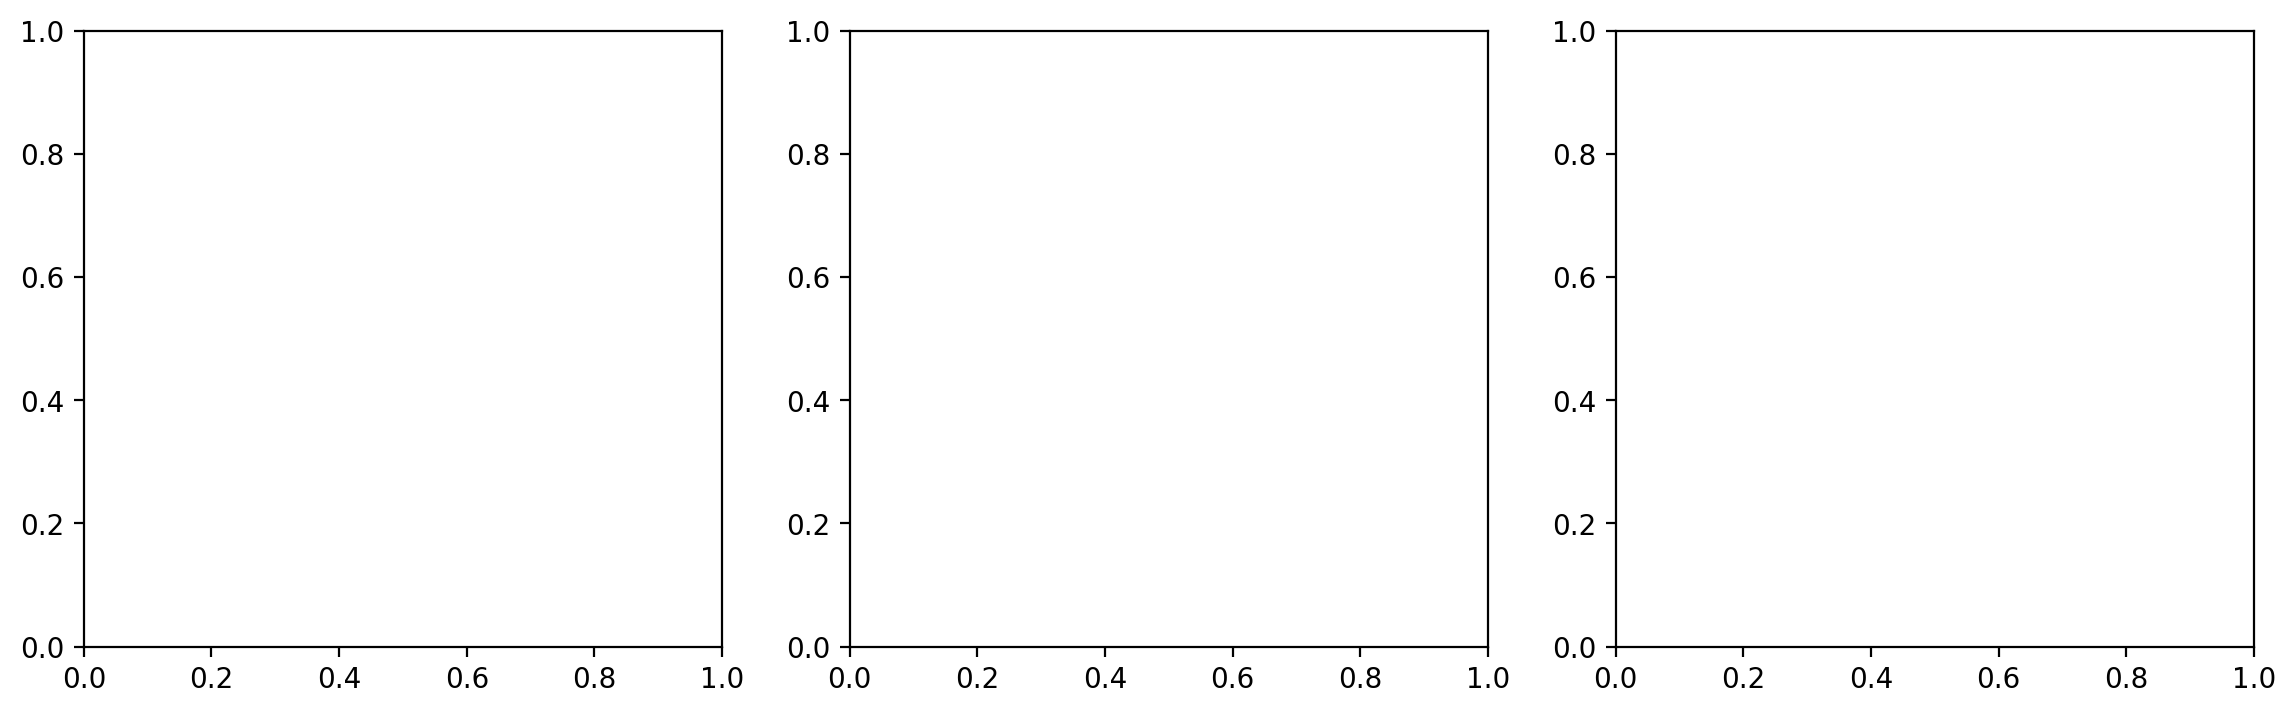

In [24]:
# === VISUALIZACIÓN ===
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metodos = ['Tradicional', 'Xu']
colores = ['steelblue', 'coral']

# Cross-Entropy
ax = axes[0]
vals = [eval_trad['ce'], eval_xu['ce']]
ax.bar(metodos, vals, color=colores)
ax.set_ylabel('Cross-Entropy (bits)')
ax.set_title('Cross-Entropy\n(menor=mejor)')
ax.axhline(y=5, color='green', linestyle='--', alpha=0.5)

# JS Divergence
ax = axes[1]
vals = [eval_trad['js'], eval_xu['js']]
ax.bar(metodos, vals, color=colores)
ax.set_ylabel('JS Divergence')
ax.set_title('JS Divergence\n(menor=más similar)')

# Longest Copy
ax = axes[2]
vals = [eval_trad['lc'], eval_xu['lc']]
ax.bar(metodos, vals, color=colores)
ax.set_ylabel('Notas')
ax.set_title('Longest Copy\n(menor=más original)')

plt.tight_layout()
plt.show()

---
# PARTE D: Experimentos
---

In [13]:
# === CONFIGURACIÓN DE EXPERIMENTOS ===
ARCHIVOS = [
    PROJECT_ROOT / 'midis/ZeldaFantasy_1_.mid',
    PROJECT_ROOT / 'midis/Battletoads.mid',
    PROJECT_ROOT / 'midis/a_thousand.mid',
]

ORDENES = [1, 2, 3]
TEMPERATURAS = [0.8, 1.0, 1.2]
N_MUESTRAS = 3

In [14]:
def run_experiment(archivo, ordenes, temps, n_samples, length=100):
    """Ejecuta experimento variando parámetros."""
    results = []
    archivo = Path(archivo)  # Asegurar que es Path
    
    try:
        eventos = extraer_eventos(str(archivo))
        seq = [(e['nota'], e['duracion']) for e in eventos]
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()
    
    for orden in ordenes:
        cadena = CadenaDeMarkov(orden=orden)
        cadena.entrenar(seq)
        
        for temp in temps:
            for i in range(n_samples):
                mel = cadena.generar_secuencia(length, temp)
                ce = calcular_cross_entropy(cadena, mel)
                results.append({
                    'archivo': archivo.name,
                    'orden': orden,
                    'temperatura': temp,
                    'muestra': i,
                    'cross_entropy': ce,
                    'metodo': 'tradicional'
                })
    
    # Xu method
    gen_xu = GeneradorXu(str(ARCHIVO_MIDI))
    gen_xu.entrenar()
    for i in range(n_samples):
        _, mel = gen_xu.generar_pieza(length // 4)
        ce = calcular_cross_entropy(cadena, mel)
        results.append({
            'archivo': archivo.name,
            'orden': 'N/A',
            'temperatura': 'N/A',
            'muestra': i,
            'cross_entropy': ce,
            'metodo': 'xu'
        })
    
    return pd.DataFrame(results)

In [15]:
# === EJECUTAR (descomentar) ===
# all_results = []
# for f in ARCHIVOS:
#     if f.exists():
#         print(f"\nProcesando: {f}")
#         df = run_experiment(f, ORDENES, TEMPERATURAS, N_MUESTRAS)
#         all_results.append(df)
# 
# if all_results:
#     df_all = pd.concat(all_results)
#     print(df_all.groupby('metodo')['cross_entropy'].agg(['mean','std']))

---
## Resumen de Métricas

| Métrica | Qué mide | Rango ideal |
|---------|----------|-------------|
| **Cross-Entropy** | Coherencia según modelo | 3-8 bits |
| **Perplexity** | Opciones efectivas por paso | 5-20 |
| **JS Divergence** | Similaridad distribucional | < 0.15 |
| **Longest Copy** | Plagio/originalidad | < 15 notas |